In [1]:
import tensorflow as tf 
from tensorflow import keras 
from tensorflow.keras import layers 
from tensorflow.keras import Model
from tensorflow.keras.layers import Input, Conv2D, Activation, MaxPooling2D, Dropout, Flatten

import tensorflow_addons as tfa
import cv2
import os 
import numpy as np
from glob import glob
import matplotlib.pyplot as plt
import datetime

from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.metrics import mean_absolute_error
import random 
import math
import time
import pandas as pd

In [2]:
base_models_path = 'C:/Users/user/Desktop/models/child_skin_classification'
PATH = 'C:/Users/user/Desktop/datasets/Child Skin Disease'
# PATH = '../../datasets/Child Skin Disease'
dataset = os.path.join(PATH, 'Total_Dataset')
N_RES = 300

min_num = 100
max_num = 3000 
base_num = 1000 

name_dict = {
    'Depressed scar' : 'Acne scar', 
    'Acquired tufted hemangioma' : 'Acquired tufted angioma', 
    'Cyst' : 'Epidermal cyst', 
    'Infantile hemangioma' : 'Hemangioma',
    'ILVEN': 'Inflammatory linear verrucous epidermal nevus'
}

In [3]:
def label_2_index(lbl, label_dict):
    return label_dict[lbl]

def index_2_label(idx, label_dict):
    key = [keys for keys in label_dict if (label_dict[keys] == idx)]
    return key

In [4]:
def test_generator(images, labels):
    
    for img, lbl in zip(images, labels):
        
        img = img[0].decode('utf-8')
        
        img = cv2.imread(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, (N_RES, N_RES))
        img = cv2.normalize(img, None, 0, 255, cv2.NORM_MINMAX)

        yield (img, lbl)    

In [5]:
def create_test_list(dataset, all_dict):
    
    images = []
    for i in range(7, 9):

        for key, val in all_dict.items():
            img = glob(dataset + f'/H{str(i)}/{key}/*.jpg')
            images.extend(img)

        for key, val in name_dict.items():
            img = glob(dataset + f'/H{str(i)}/{key}/*.jpg')
            images.extend(img)

        
    # # 전남대 추가
    # for key, val in all_dict.items(): 
    #     img = glob(dataset + '/H9/{key}/*.jpg')
    #     images.extend(img) 

    # for key, val in name_dict.items():
    #     img = glob(dataset + f'/H9/{key}/*.jpg')
    #     images.extend(img)

    # 고른 데이터 분배를 위한 random shuffle
    random.shuffle(images)

    # max 데이터 처리
    # count 를 돌면서 count
    # count_all_dict = all_dict.copy() 

    test_images = []
    for idx_imgs, val_imgs in enumerate(images):

        # class 통합 관련 내용 변경
        classes = val_imgs.split('/')[-1].split('\\')[0]
        # classes = val_imgs.split('/')[-2]
        
        test_images.append(val_imgs)
        
        # if classes in name_dict:
        #     if count_all_dict[name_dict[classes]] > 0:
        #         count_all_dict[name_dict[classes]] -= 1
        #         test_images.append(val_imgs)

        #     else:
        #         continue

        # else:
        #     if count_all_dict[classes] > 0:
        #         count_all_dict[classes] -= 1
        #         test_images.append(val_imgs)
        #     else:
        #         continue


    test_labels = [] 
    for img in test_images:
        lbl = img.split('/')[-1].split('\\')[0]
        # lbl = img.split('/')[-2]

        # 변경/통합 버전으로 label 처리
        if lbl in name_dict:
            lbl = name_dict[lbl]

        lbl = label_2_index(lbl, all_dict)
        test_labels.append(lbl)
        
    test_images = np.reshape(test_images, [-1, 1])
    test_labels = np.reshape(test_labels, [-1, 1])
    
    
    return test_images, test_labels

In [7]:
def create_all_dict(dataset, min_num, max_num):
    all_dict = dict() 
    count_all_dict = dict() 

    for i in range(10):
        files = os.listdir(os.path.join(dataset, f'H{i}'))
        
        for f in files:
            # imgs = glob(os.path.join(dataset, f'H{i}', f) + '/*.jpg')
            imgs = glob(f'{dataset}/H{i}/{f}/*.jpg')
            
            # print(f)

            # class 통합 관련 내용 변경
            if f in name_dict: 
                f = name_dict[f]
            
            if f not in count_all_dict:
                count_all_dict[f] = len(imgs) 
            else:
                count_all_dict[f] += len(imgs)

    new_count_dict = count_all_dict.copy()

    # print(new_count_dict)

    # 데이터 정제
    for key, val in count_all_dict.items():
        if val < min_num:
            del new_count_dict[key]

        if val > max_num:
            new_count_dict[key] = max_num
            

    idx_num = 0 
    for idx, key in new_count_dict.items():
        # print(idx)
        all_dict[idx] = idx_num 
        idx_num += 1 
        
        
    return all_dict, count_all_dict

In [8]:
all_dict, count_all_dict = create_all_dict(dataset, min_num, max_num) 
N_CLASSES = len(all_dict)

In [9]:
test_images, test_labels = create_test_list(dataset, all_dict)

In [23]:
# test_images, test_labels
x_test = [] 
y_test = [] 
# N_RES = 256

for img, lbl in zip(test_images, test_labels): 
    # print(img[0])
    
    img = cv2.imread(img[0], cv2.COLOR_BGR2RGB)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (N_RES, N_RES))
    # img = cv2.normalize(img, None, 0, 255, cv2.NORM_MINMAX)
    
    x_test.append(img) 
    y_test.append(lbl) 
    
x_test = np.reshape(x_test, [-1, N_RES, N_RES, 3])
y_test = np.reshape(y_test, [-1, 1])

x_test.shape, y_test.shape

((41401, 300, 300, 3), (41401, 1))

In [10]:
model = keras.models.load_model(os.path.join(base_models_path, 'checkpoint_20220715-134142_efficientb4_kfold_5_2.h5'))
model

In [24]:
# print(model.predict(x_test))
x_preds = model.predict(x_test)

In [29]:
x_preds.shape

(41401, 127)

In [33]:
x_test[0].shape

(300, 300, 3)

In [36]:
x_preds[0].shape

(127,)

In [90]:
a = np.array([5, 6, 1, 2])
# np.argmax(sorted(a))
b = a.argsort()[::-1]
# b
idx = np.where(b == 0)
b, a, a[idx], idx
# b[0], b
# b.index(0)
# b[b == 0]
# c = np.where(b == 0)
# b, c, b[c]
# ranks = np.empty_like(b)
# ranks

(array([1, 0, 3, 2], dtype=int64),
 array([5, 6, 1, 2]),
 array([6]),
 (array([1], dtype=int64),))

In [119]:
aaaa = [6.30330935e-04, 4.90217295e-04, 6.12758507e-04, 2.67793727e-03,
 6.36303594e-06, 2.22264898e-05, 3.62888182e-04, 4.39701078e-04,
 2.63311013e-05, 5.55565748e-06, 6.47425713e-06, 1.89268048e-05,
 4.07765729e-05, 2.26406623e-02, 9.11571042e-05, 6.18841732e-03,
 7.73931024e-05, 1.01233136e-05, 1.88006163e-06, 1.19978677e-06,
 2.67610158e-04, 6.86927175e-04, 1.41607397e-05, 1.64569152e-04,
 2.65339349e-06, 3.02260050e-05, 2.38748752e-02, 3.02293082e-03,
 3.98214645e-04, 2.46040174e-04, 2.46733951e-04, 7.21293887e-08,
 7.64843216e-03, 1.63057703e-05, 1.61970311e-05, 2.93756020e-04,
 2.38298345e-02, 4.56202775e-04, 1.87355035e-03, 4.31087938e-05,
 3.48765366e-06, 1.67519099e-03, 3.01648124e-05, 1.79464594e-04,
 8.20382593e-06, 8.94744007e-05, 8.45119721e-05, 6.35110473e-06,
 2.09865684e-04, 1.87734564e-04, 9.23210056e-04, 2.05741162e-06,
 5.46568590e-05, 1.64246303e-05, 8.56200568e-05, 8.95657390e-03,
 2.61801644e-04, 5.18291126e-05, 4.66361351e-04, 3.44430555e-05,
 2.62367427e-02, 7.95343192e-04, 4.89043677e-03, 7.16908798e-02,
 2.39945275e-05, 7.42432985e-06, 7.22388868e-05, 3.37395541e-05,
 9.88277979e-03, 2.56964180e-04, 1.59858137e-05, 4.28861131e-06,
 6.58366989e-05, 5.29513974e-03, 7.81325914e-04, 5.38076565e-04,
 4.17727688e-06, 3.84730339e-01, 6.65038452e-03, 9.96667513e-05,
 4.17502679e-06, 1.92581471e-02, 3.69498002e-06, 5.16033015e-06,
 5.19630112e-06, 1.81623018e-05, 1.04260025e-05, 1.50609403e-05,
 2.11217688e-04, 1.27337389e-05, 1.54183130e-04, 5.35375765e-03,
 2.46068954e-01, 1.63212626e-05, 3.95489496e-06, 2.46684998e-04,
 7.61996442e-03, 1.74896524e-03, 3.75623140e-03, 6.81330916e-03,
 3.98632801e-06, 5.18500819e-05, 4.08211008e-06, 6.28791226e-04,
 2.35417883e-05, 8.11612117e-05, 9.84592363e-03, 1.26898351e-06,
 8.80608428e-03, 1.79678586e-03, 6.06403919e-05, 1.22976155e-04,
 4.07868793e-05, 4.28831839e-07, 3.25917172e-05, 1.56510810e-04,
 6.34152741e-07, 3.17605998e-04, 8.85064026e-07, 2.72595644e-05,
 2.83196164e-06, 6.33877353e-04, 1.45897281e-03, 2.12509985e-05,
 1.08223154e-04, 4.97548841e-04, 6.10602200e-02]


# print(aaaa.sort())
bbbb = aaaa.sort() 
print(bbbb)

None


In [80]:
a = 1.6197031 / (10^5)
b = 4.3108794 / (10^5)

if a > b:
    print(1)
else:
    print(2)

2


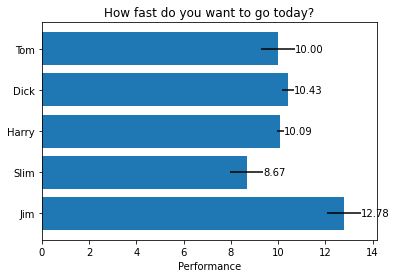

In [178]:
# Fixing random state for reproducibility
np.random.seed(19680801)

# Example data
people = ('Tom', 'Dick', 'Harry', 'Slim', 'Jim')
y_pos = np.arange(len(people))
performance = 3 + 10 * np.random.rand(len(people))
error = np.random.rand(len(people))

fig, ax = plt.subplots()

hbars = ax.barh(y_pos, performance, xerr=error, align='center')
ax.set_yticks(y_pos, labels=people)
ax.invert_yaxis()  # labels read top-to-bottom
ax.set_xlabel('Performance')
ax.set_title('How fast do you want to go today?')

# Label with specially formatted floats
ax.bar_label(hbars, fmt='%.2f')
# ax.set_xlim(right=15)  # adjust xlim to fit labels

plt.show()

In [179]:
performance

array([10.00367304, 10.42750809, 10.09280011,  8.66745522, 12.77785333])

numpy.ndarray

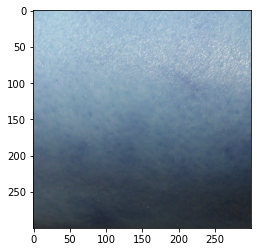

In [164]:
plt.imshow(x_test[0])
type(x_test[0])

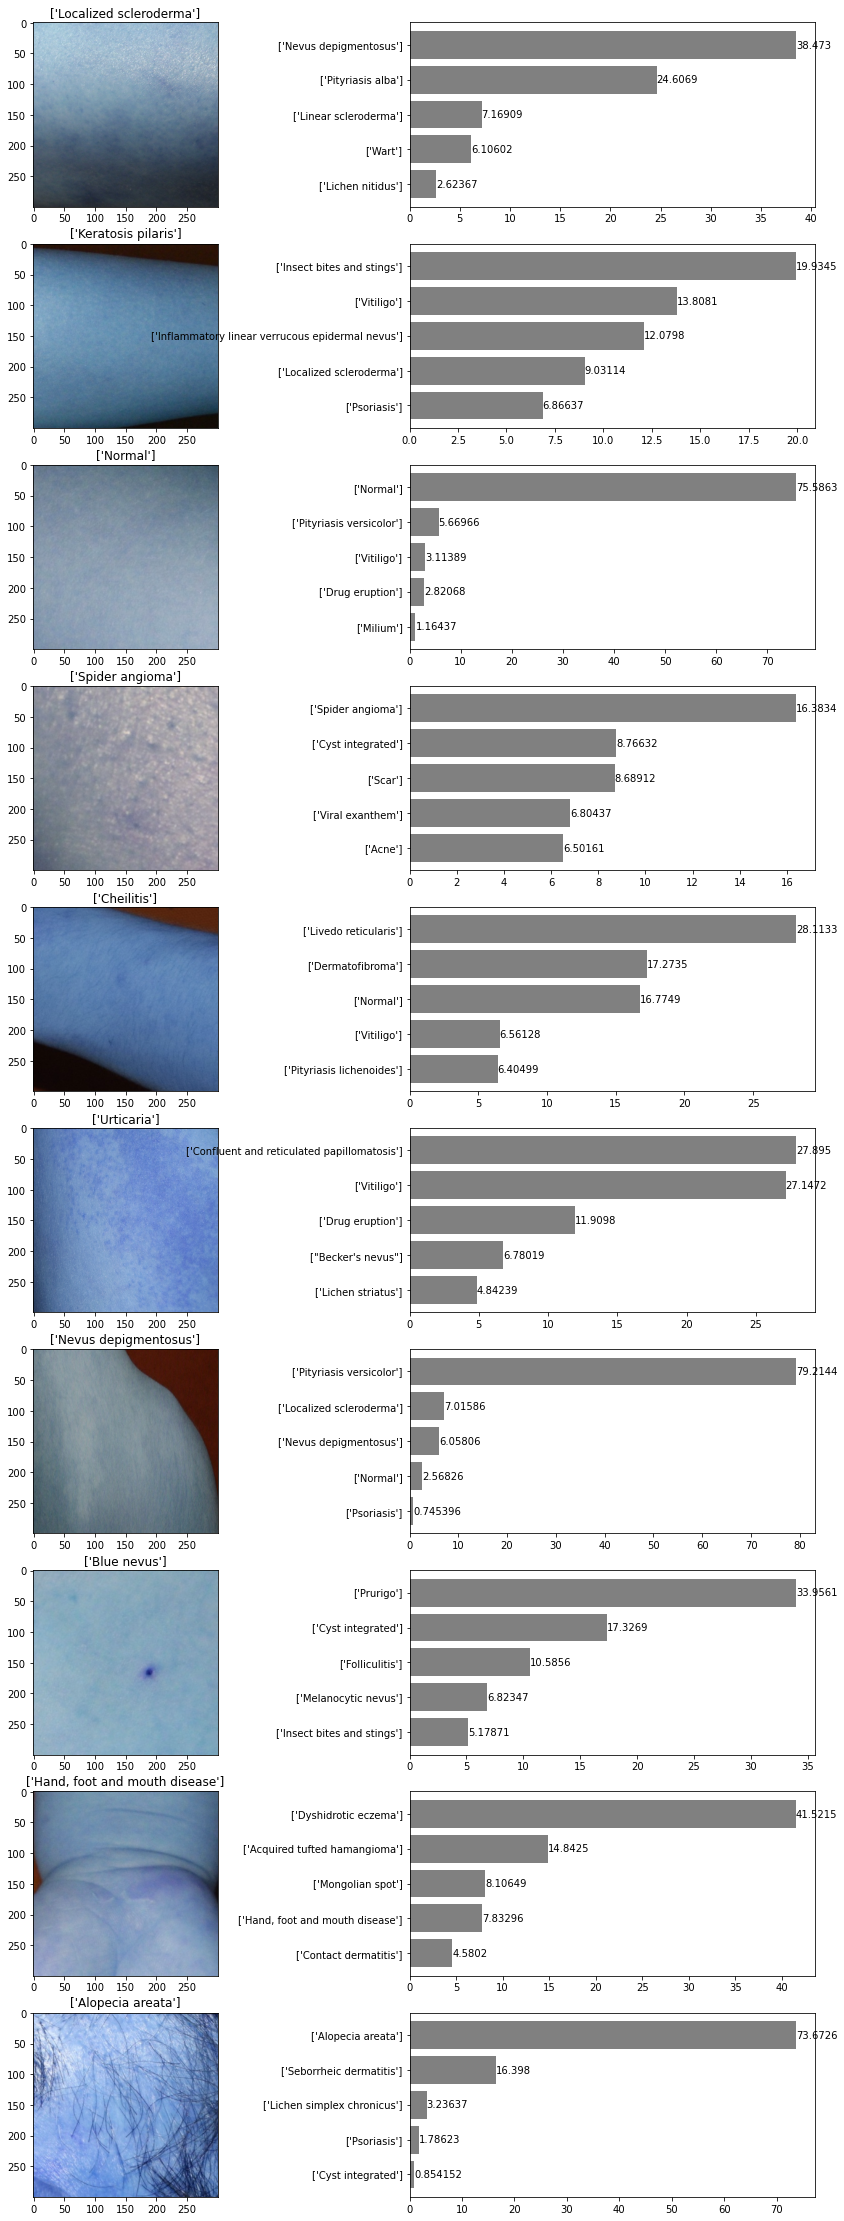

In [183]:
num = 10
fig, ax = plt.subplots(figsize=(16,40), ncols=2, nrows=num)

row = 0 
for img, lbl in zip(x_test[:num], y_test[:num]):
    ax[row, 0].imshow(img)
    ax[row, 0].set_title(index_2_label(lbl, all_dict))
    
    logits = model.predict(img[tf.newaxis, ...])
    prediction = logits[0]
    
    # 가장 높은 확률의 예측값 5개를 뽑음
    # top_5_predict = prediction.argsort()[::-1][:5]
    top_5_predict = np.argsort(prediction)[::-1][:5]
    top_5_values = np.sort(prediction)[::-1][:5]
    
    # print(top_5_values)
    
    labels = [index_2_label(index, all_dict)for index in top_5_predict]
    color = ['gray'] * 5
    color = color[::-1]
    hbars = ax[row, 1].barh(range(5), prediction[top_5_predict][::-1] * 100, color=color)
    ax[row, 1].set_yticks(range(5), labels[::-1])  
    ax[row, 1].bar_label(hbars)
    
    row += 1
    



In [158]:
# fig, ax = 
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(16,16))
num = 3

for img, lbl in zip(x_test[:num], y_test[:num]):
    # print(num)
    plt.subplot(3 ,2,c*2+1)
    # plt.imshow(img)
    # plt.title(index_2_label(lbl, all_dict))
    # ax.axis('off')
    
    # plt.subplot(num,2,c*2+2)
    # logits = model.predict(img[tf.newaxis, ...])
    # prediction = logits[0]
    
    # top_5_predict = prediction.argsort()[::-1][:5]
    
    # labels = [index_2_label(index, all_dict)for index in top_5_predict]
    # color = ['gray'] * 5
    # color = color[::-1]
    # plt.barh(range(5), prediction[top_5_predict][::-1] * 100, color=color)
    # plt.yticks(range(5), labels[::-1])  
    
    c += 1  
    



ValueError: num must be 1 <= num <= 6, not 13

<Figure size 1152x1152 with 0 Axes>